In [1]:
%matplotlib inline
from __future__ import division, print_function

import numpy as np
import matplotlib.pyplot as plt
import corner
plt.style.use('jpg.mplstyle')

import pymfit

img_fn = '../data/test-galaxy-2.fits'
mask_fn = '../local_data/mask.fits'
config_fn = '../local_data/config.txt'
boot_fn = '../local_data/boots.dat'
best_fit_fn = '../local_data/best-fit.dat'

# Bootstrapping it
- This is a test of imfit's bootstrap resampling option
- I'll try it with 1000 bootstraps

In [2]:
%%time
Nboots = 1000
mask_kws = dict(out_fn=mask_fn, thresh=1.2, kern_sig=1.0, backsize=10, 
                obj_rmin=5, grow_sig=3.0, use_hsc_mask=False)
mask = pymfit.make_mask(img_fn, **mask_kws)
config = pymfit.sersic_config(img_shape=img_fn)
sersic = pymfit.run(img_fn+'[1]', config_fn, mask_fn, img_fn+'[3]', 
                    out_fn=best_fit_fn, bootstrap=Nboots, bootstrap_fn=boot_fn)

CPU times: user 50.6 ms, sys: 17.9 ms, total: 68.4 ms
Wall time: 2min 51s


It took 3 minutes on my 2012 Macbook Pro (damn I need a new computer). Note this is *without* PSF convolution.

`imfit` is distributed with `python` code to fetch the bootstrap results. These functions are in `pymfit.utils`:

In [3]:
col_names, boot_results = pymfit.utils.GetBootstrapOutput(boot_fn)
col_names = [cn[:-2] for cn in col_names]

Let's visualize the results with `corner`:

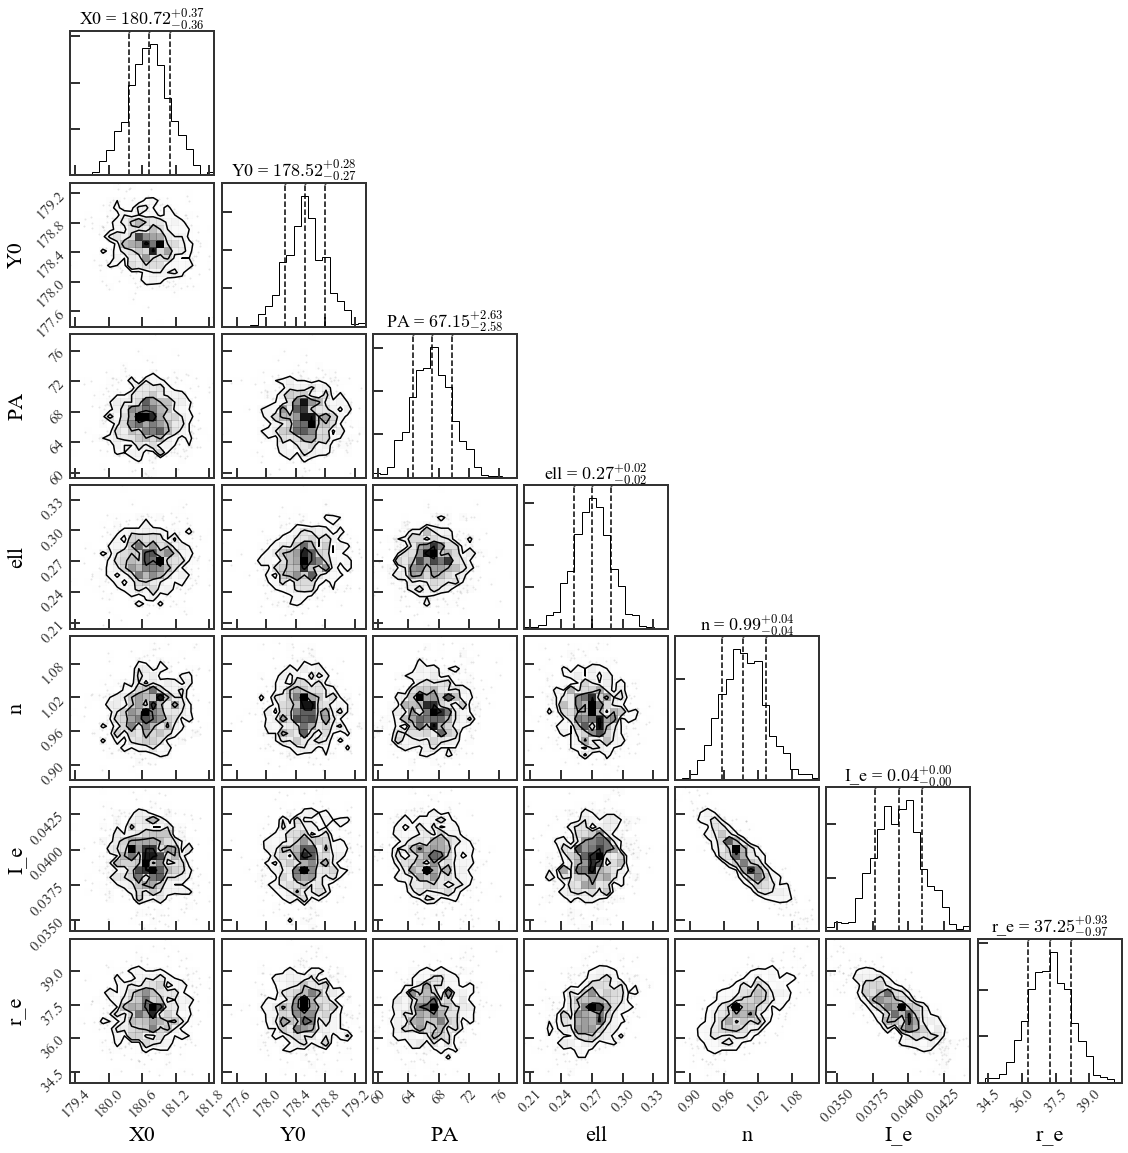

In [4]:
corner.corner(boot_results, labels=col_names, quantiles=[.16, .50, .84], show_titles=True);

Not surprisingly, we see clear correlations between $r_e$, $n$, and $I_e$.

To get distributions of more useful parameters, I'll use `pymfit.Sersic` objects. However, we should probably make a a separate function for this, which will be much simpler.  

In [5]:
mu_0 = []
m_tot = []
for boot in boot_results:
    params = dict((k,v) for k,v in zip(col_names, boot))
    sersic = pymfit.Sersic(params)
    mu_0.append(sersic.mu_0)
    m_tot.append(sersic.m_tot)    
r_eff = boot_results[:,6]*0.168
ell = boot_results[:,3]

Here are the distributions for central surface brightness, total magnitude, and effective radius in arcsec:

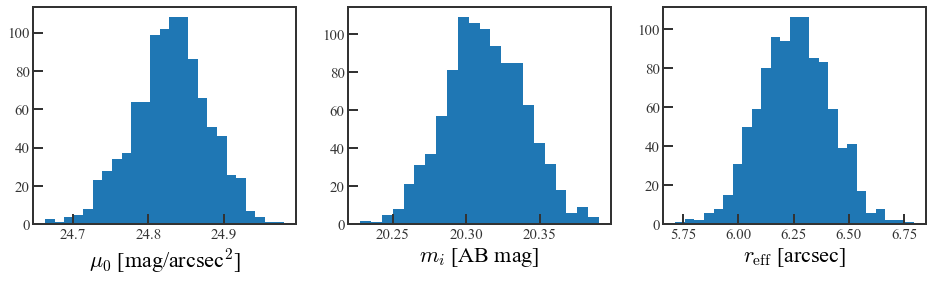

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].hist(mu_0, bins='auto')
ax[1].hist(m_tot, bins='auto')
ax[2].hist(r_eff, bins='auto')
ax[0].set_xlabel('$\mu_0$ [mag/arcsec$^2$]')
ax[1].set_xlabel('$m_i$ [AB mag]')
ax[2].set_xlabel('$r_\mathrm{eff}$ [arcsec]');

We can use these to calculate our parameter estimations and uncertainties:

In [7]:
def param_value(boots):
    p = np.percentile(boots, [16, 50, 84])
    return p[1], p[1]-p[0], p[2]-p[1]

names = ['mu_0', 'm_tot', 'r_eff', 'ell']
boots = [mu_0, m_tot, r_eff, ell]
for name, boot in zip(names, boots):
    value = param_value(boot)
    print('{:5} = {:5.2f} (+{:.3f}, -{:.3f})'.format(name, *value))    

mu_0  = 24.83 (+0.051, -0.047)
m_tot = 20.31 (+0.026, -0.028)
r_eff =  6.26 (+0.163, -0.157)
ell   =  0.27 (+0.018, -0.018)
